## Agenda

- Compare the true vs. training error of an ML model
- Demo on Bias-variance trade-off?
- How to do model selection via cross validation (CV)?
- Grid search to tune hyperparameters
- Model selection in high dimension via regularization

### Generating Training Data

First we will write a function to generate a random sample. The data generation model is the following:

$$f(x) + \epsilon$$
with $\epsilon\sim\mathcal{N}(0,1)$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def f(size):
    '''
    Returns a sample with 'size' instances without noise.
    '''
    x = np.linspace(0, 4.5, size)
    y = 2 * np.sin(x * 1.5)
    return (x,y)

In [3]:
def sample(size):
    '''
    Returns a sample with 'size' instances.
    '''
    x = np.linspace(0, 4.5, size)
    y = 2 * np.sin(x * 1.5) + np.random.randn(x.size)
    return (x,y)

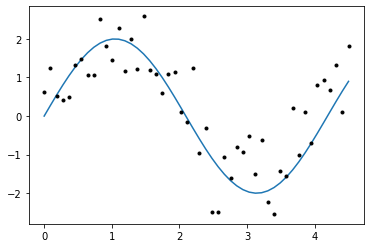

In [14]:
f_x, f_y = f(50)
plt.plot(f_x, f_y)
x, y = sample(50)
plt.plot(x, y, 'k.')
plt.show()

#### Model fitting
We will use ordinary least square to fit a polynomial to the data.

For each sample $x_{i}$ we build a vector $(1 , x_{i} , x_{i}^{2} , \dots , x_{i}^{n})$ and we use OLS to fit a function to the training data.

In [5]:
from sklearn.linear_model import LinearRegression

In [6]:
def fit_polynomial(X, y, degree):
    '''
    Fits a polynomial to the input sample.
    (x,y): input sample
    degree: polynomial degree
    '''
    model = LinearRegression()
    model.fit(np.vander(X, degree + 1), y)
    return model

In [7]:
def apply_polynomial(model, X):
    '''
    Evaluates a linear regression model in an input sample
    model: linear regression model
    x: input sample
    '''
    degree = model.coef_.size - 1
    y = model.predict(np.vander(X, degree + 1))
    return y

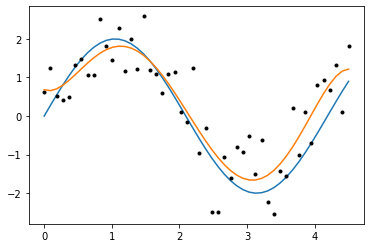

In [21]:
model = fit_polynomial(x, y, 5)
p_y = apply_polynomial(model, x)
plt.plot(f_x, f_y)
plt.plot(x, y, 'k.')
plt.plot(x, p_y)
plt.show()

### Plotting bias and variance
We calculate bias an variance among models for different polynomial degrees. Bias, variance and error are plotted against different degree values.

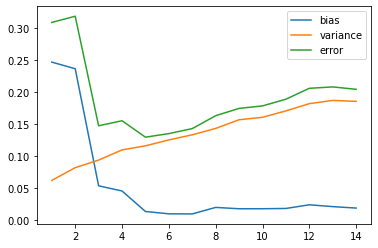

In [22]:
n_samples = 20
f_x, f_y = f(n_samples)
n_models = 100
max_degree = 15

var_vals =[]
bias_vals = []
error_vals = []


for degree in range(1, max_degree): # iterating over complexity of models
    avg_y = np.zeros(n_samples) # store avg prediction by running the model repreatedly
    models = [] # storing predictions for computing variance
    
    for i in range(n_models): # for each degree, model repeatedly to get average prediction
        (x,y) = sample(n_samples)
        model = fit_polynomial(x, y, degree)
        p_y = apply_polynomial(model, x)
        avg_y = avg_y + p_y
        models.append(p_y)
    
    avg_y = avg_y / n_models
    #f term is true function, not known for most models
    bias_2 = np.linalg.norm(avg_y - f_y)/f_y.size
    bias_vals.append(bias_2)

    variance = 0
    for p_y in models:
        variance += np.linalg.norm(avg_y - p_y)
    
    variance /= f_y.size*n_models
    var_vals.append(variance)
    error_vals.append(variance + bias_2)

# plotting the three against complexity of the model
plt.plot(list(range(1, max_degree)), bias_vals, label='bias')
plt.plot(list(range(1, max_degree)), var_vals, label='variance')
plt.plot(list(range(1, max_degree)), error_vals, label='error')
plt.legend()
plt.show()

### How to approximate true error: Cross Validation
Since in a real problem, we don't have access to the **true function** $f$. We cannot exactly calculate the error, however we can approximate it using cross validation.

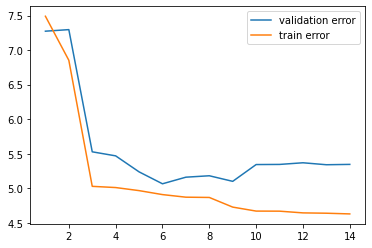

In [35]:
n_samples = 30
# train sample
train_x, train_y = sample(n_samples)

# validation sample
test_x, test_y = sample(n_samples)
max_degree = 15
test_error_vals = []
train_error_vals = []

for degree in range(1, max_degree):
    model = fit_polynomial(train_x, train_y, degree)
    
    p_y = apply_polynomial(model, train_x)
    train_error_vals.append(np.linalg.norm(train_y - p_y))
    
    p_y = apply_polynomial(model, test_x)
    test_error_vals.append(np.linalg.norm(test_y - p_y))

plt.plot(list(range(1, max_degree)), test_error_vals, label='validation error')
plt.plot(list(range(1, max_degree)), train_error_vals, label='train error')
plt.legend()
plt.show()

### Model selection: House price prediction
Returning to Boston housing dataset again

In [36]:
# conventional way to import pandas
import pandas as pd

In [37]:
from sklearn.datasets import load_boston

dataset = load_boston()
X = pd.DataFrame(dataset.data, columns=dataset.feature_names)
y = dataset.target

X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


### Regularized Linear Regression

Let's try out Lasso and Ridge regularization

**Lasso**: $$\min_{\textbf{w}} l(\textbf{w}) = \frac{1}{2} ||\textbf{X}\textbf{w} - \textbf{y}||^2 + \alpha ||\textbf{w}||_1$$

**Ridge**: $$\min_{\textbf{w}} l(\textbf{w}) = \frac{1}{2} ||\textbf{X}\textbf{w} - \textbf{y}||^2 + \alpha ||\textbf{w}||^2_2$$

**Goal**: Select the best tuning parameters (aka "hyperparameters") for Ridge regression on Boston dataset

In [38]:
from sklearn.model_selection import cross_val_score

In [39]:
from sklearn.linear_model import Ridge

# 10-fold cross-validation with a fixed alpha value
# instantiate
ridge = Ridge(alpha = 1)
#cv= is number of folds
scores = cross_val_score(ridge, X, y, cv=10, scoring='neg_mean_absolute_error')
print(scores)

[-2.13853137 -2.68663317 -2.35160069 -4.64612651 -3.9194842  -3.46659308
 -2.70321248 -9.61792426 -5.06488956 -2.59385822]


In [40]:
# use average accuracy as an estimate of out-of-sample accuracy
print(scores.mean())

-3.918885353336995


In [41]:
# search for an optimal value of alpha
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
mean_square_err = []
for alpha in alphas:
    ridge = Ridge(alpha = alpha)
    scores = cross_val_score(ridge, X, y, cv=10, scoring='neg_mean_absolute_error')
    mean_square_err.append(scores.mean())
print(mean_square_err)

[-4.004926034493995, -4.004740769018783, -4.002908442310554, -3.986522079309625, -3.918885353336995, -3.875238974048405, -3.7794750013861864, -3.977908105147828]


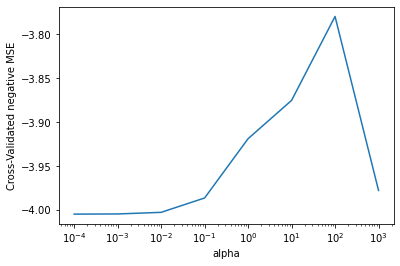

In [43]:
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.semilogx(alphas, mean_square_err)
plt.xlabel('alpha')
plt.ylabel('Cross-Validated negative MSE')
#largest value is better
plt.show()

### More efficient parameter tuning using GridSearchCV
Allows you to define a grid of parameters that will be searched using K-fold cross-validation

In [44]:
from sklearn.model_selection import GridSearchCV

In [45]:
# define a dictionary with the parameter name as key and values that should be searched
param_grid = {'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
print(param_grid)

{'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}


In [46]:
# instantiate the model
ridge = Ridge()
# instantiate the grid
grid = GridSearchCV(ridge, param_grid=param_grid, cv=10, scoring='neg_mean_absolute_error', n_jobs=-2, 
                    return_train_score=True)

**You can set n_jobs = -1 to run computations in parallel (if supported by your computer and OS)**

In [47]:
# fit the grid with data
grid.fit(X, y)

GridSearchCV(cv=10, estimator=Ridge(), n_jobs=-2,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [48]:
pd.DataFrame(grid.cv_results_)[['mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score', 'params']]

,mean_train_score,std_train_score,mean_test_score,std_test_score,params
0,-3.247637,0.234645,-4.004926,2.083609,{'alpha': 0.0001}
1,-3.247577,0.234637,-4.004741,2.083694,{'alpha': 0.001}
2,-3.246988,0.234551,-4.002908,2.084535,{'alpha': 0.01}
3,-3.242172,0.233830,-3.986522,2.092081,{'alpha': 0.1}
4,-3.236548,0.233910,-3.918885,2.119053,{'alpha': 1}
5,-3.283031,0.245019,-3.875239,2.019836,{'alpha': 10}
6,-3.402527,0.203414,-3.779475,1.494841,{'alpha': 100}
7,-3.680991,0.155635,-3.977908,1.179200,{'alpha': 1000}


In [57]:
# examine the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

-3.7781328210864364
{'alpha': 100}
Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)


### Feature selection using Lasso over k-fold cross validation

In [67]:
from sklearn.linear_model import Lasso

# instantiate
lasso = Lasso()

# instantiate the grid
grid = GridSearchCV(lasso, param_grid=param_grid, cv=10, scoring='neg_mean_absolute_error', n_jobs=-2, 
                    return_train_score=True)

In [68]:
# fit the grid with data
grid.fit(X, y)

GridSearchCV(cv=10, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [69]:
pd.DataFrame(grid.cv_results_)[['mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score', 'params']]

,mean_train_score,std_train_score,mean_test_score,std_test_score,params
0,-3.248612,0.235483,-4.002183,2.076804,{'alpha': 0.0001}
1,-3.247057,0.235451,-3.997828,2.078813,{'alpha': 0.001}
2,-3.236155,0.233863,-3.958326,2.097952,{'alpha': 0.01}
3,-3.297043,0.248988,-3.897150,2.097351,{'alpha': 0.1}
4,-3.586285,0.223293,-4.066074,1.465521,{'alpha': 1}
5,-4.378995,0.195251,-4.765782,1.559530,{'alpha': 10}
6,-5.797802,0.305120,-6.272503,1.903503,{'alpha': 100}
7,-6.634103,0.351411,-7.039384,3.026005,{'alpha': 1000}


In [70]:
# examine the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

-3.897149997884719
{'alpha': 0.1}
Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)


In [71]:
best_model = grid.best_estimator_

In [74]:
coeff

array([-0.09678792,  0.04917922, -0.03642541,  0.95709698, -0.        ,
        3.69894259, -0.01000634, -1.16012114,  0.27411189, -0.01456675,
       -0.77100252,  0.01032665, -0.56950927])

In [72]:
coeff = best_model.coef_
coeff_used = np.sum(coeff !=0)
print('Number of features retained:', coeff_used)

Number of features retained: 12


In [75]:
X.shape

(506, 13)

References:
- https://gist.github.com/fabgoos/6788818
- https://scikit-learn.org/stable/modules/model_evaluation.html (Different scoring methods)   